# Unemployment Analysis

- Your analysis here
  
---

In [325]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [326]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [327]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [328]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [410]:
%pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 3.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [716]:
from scipy import stats

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [723]:
from scipy.stats import shapiro

In [329]:
import seaborn as sns
import statsmodels.api as sm

In [330]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import os





In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [806]:
import statsmodels.formula.api as smf

In [332]:
#find current directory
current_dir = os.getcwd()
print(current_dir)

/Users/wenlirui/Desktop/project1/Code


In [666]:
#load yearly education data
education_to_load =os.path.join(current_dir, "Data", "Education attainment.csv")
education_data=pd.read_csv(education_to_load)
education_data.head()


,year,total,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years)
0,2022.0,"226,274",3%,28%,38%
1,2021.0,"224,580",3%,28%,38%
2,2020.0,"223,058",3%,28%,38%
3,2019.0,"221,478",3%,28%,36%
4,2018.0,"219,830",3%,29%,35%


In [667]:
#create month column for each year in education data
value_count = education_data['year'].count()
months_data = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count   # Repeat months for each year
}
months_df = pd.DataFrame(months_data)
monthly_edu = pd.concat([education_data]*12, ignore_index = True)
monthly_edu = monthly_edu.sort_values(by=['year'])
monthly_edu = monthly_edu.reset_index(drop=True)

In [668]:
monthly_edu_data = pd.concat([monthly_edu, months_df], axis=1)
monthly_edu_data.head()

,year,total,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years),Month
0,1940.0,"74,776",46%,14%,5%,01
1,1940.0,"74,776",46%,14%,5%,02
2,1940.0,"74,776",46%,14%,5%,03
3,1940.0,"74,776",46%,14%,5%,04
4,1940.0,"74,776",46%,14%,5%,05


In [669]:
#drop NA data
monthly_edu_data= monthly_edu_data.dropna()
monthly_edu_data.head()

,year,total,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years),Month
0,1940.0,"74,776",46%,14%,5%,01
1,1940.0,"74,776",46%,14%,5%,02
2,1940.0,"74,776",46%,14%,5%,03
3,1940.0,"74,776",46%,14%,5%,04
4,1940.0,"74,776",46%,14%,5%,05


In [670]:
# convert year data type to integer
monthly_edu_data['year'] = monthly_edu_data['year'].astype(int)

#create year-month column
monthly_edu_data['YearMonth'] = pd.to_datetime(monthly_edu_data['year'].astype(str) + '-' + monthly_edu_data['Month'].astype(str) + '-01')
#Clean up Education Data
monthly_edu_data=monthly_edu_data[['YearMonth','% Highest degree is middle school', '% Highest degree is High School', '% Highest degree is  College (4 + years)']]
#convert degree % columns type from object to float
monthly_edu_data['% Highest degree is middle school']=monthly_edu_data['% Highest degree is middle school'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is High School']=monthly_edu_data['% Highest degree is High School'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is  College (4 + years)']=monthly_edu_data['% Highest degree is  College (4 + years)'].str.rstrip('%').astype(float) / 100
monthly_edu_data.head()


,YearMonth,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years)
0,1940-01-01,0.46,0.14,0.05
1,1940-02-01,0.46,0.14,0.05
2,1940-03-01,0.46,0.14,0.05
3,1940-04-01,0.46,0.14,0.05
4,1940-05-01,0.46,0.14,0.05


In [338]:
nan_counts = monthly_edu_data.isna().sum()

print("Number of NaNs in each column:")
print(nan_counts)


Number of NaNs in each column:
YearMonth                                   0
% Highest degree is middle school           0
% Highest degree is High School             0
% Highest degree is  College (4 + years)    0
dtype: int64


In [339]:
#exam unemployment data
unemployment_to_load = os.path.join(current_dir, "Data", "MonthlyUnemployment.csv")
unemployment_data = pd.read_csv(unemployment_to_load)
unemployment_data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1948,3.4,3.8,4.0,3.9,3.5,3.6,3.6,3.9,3.8,3.7,3.8,4.0
1,1949,4.3,4.7,5.0,5.3,6.1,6.2,6.7,6.8,6.6,7.9,6.4,6.6
2,1950,6.5,6.4,6.3,5.8,5.5,5.4,5.0,4.5,4.4,4.2,4.2,4.3
3,1951,3.7,3.4,3.4,3.1,3.0,3.2,3.1,3.1,3.3,3.5,3.5,3.1
4,1952,3.2,3.1,2.9,2.9,3.0,3.0,3.2,3.4,3.1,3.0,2.8,2.7


In [671]:
#transform unemployment data
unemployment_df = unemployment_data.melt(id_vars=['Year'], var_name='Month', value_name='Unemployment Rate')

month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
    # Add more months as needed
}
unemployment_df['MonthNum'] = unemployment_df['Month'].map(month_map)
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01'
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01' 
unemployment_df = unemployment_df[['YearMonth', 'Unemployment Rate' ]]
unemployment_df['YearMonth'] = pd.to_datetime(unemployment_df['YearMonth'])
unemployment_df.head()

,YearMonth,Unemployment Rate
0,1948-01-01,3.4
1,1949-01-01,4.3
2,1950-01-01,6.5
3,1951-01-01,3.7
4,1952-01-01,3.2


In [672]:
#exam men unemployment data
men_unemploy_to_load = os.path.join(current_dir, "Data", "Men_Unemployment.csv")
unemployment_men = pd.read_csv(men_unemploy_to_load)
unemployment_men ['YearMonth'] = pd.to_datetime(unemployment_men ['DATE'])
unemployment_men.head()

,DATE,LNS14000001,YearMonth
0,1948-01-01,3.4,1948-01-01
1,1948-02-01,3.6,1948-02-01
2,1948-03-01,3.8,1948-03-01
3,1948-04-01,3.8,1948-04-01
4,1948-05-01,3.5,1948-05-01


In [673]:
#exam women unemployment data
women_unemploy_to_load = os.path.join(current_dir, "Data", "Women_Unemployment.csv")
unemployment_women = pd.read_csv(women_unemploy_to_load )
unemployment_women ['YearMonth'] = pd.to_datetime(unemployment_women ['DATE'])
unemployment_women.head()

,DATE,LNS14000002,YearMonth
0,1948-01-01,3.3,1948-01-01
1,1948-02-01,4.5,1948-02-01
2,1948-03-01,4.4,1948-03-01
3,1948-04-01,4.3,1948-04-01
4,1948-05-01,3.7,1948-05-01


In [840]:
#load and exam gdp data
gdp_to_load = os.path.join(current_dir, "Data", "MonthlyGDP.csv")
gdp_data = pd.read_csv(gdp_to_load)
gdp_data.head()

,DATE,USALORSGPNOSTSAM
0,2/1/47,102.3044
1,3/1/47,101.9178
2,4/1/47,101.5401
3,5/1/47,101.1850
4,6/1/47,100.8719


In [841]:
# Define a function to correctly parse two-digit years
def parse_date(date_str):
    # Use pd.to_datetime with dayfirst=False for m/d/y format
    date = pd.to_datetime(date_str, format='%m/%d/%y', errors='coerce')
    # Fix the century if necessary
    if date.year > pd.Timestamp.now().year:
        date = date.replace(year=date.year - 100)
    return date

# Create a YearMonth column
gdp_data['YearMonth'] = gdp_data['DATE'].apply(parse_date)
gdp_data['YearMonth'] = gdp_data['YearMonth'].dt.strftime('%Y-%m-%d')
gdp_data = gdp_data[['YearMonth','USALORSGPNOSTSAM']]
gdp_data['YearMonth'] = pd.to_datetime(gdp_data['YearMonth'])

#Prepare data to calc gdp growth
gdp_data['USALORSGPNOSTSAM1']= gdp_data['USALORSGPNOSTSAM'].shift(-1)

gdp_data.head()

,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1
0,1947-02-01,102.3044,101.9178
1,1947-03-01,101.9178,101.5401
2,1947-04-01,101.5401,101.1850
3,1947-05-01,101.1850,100.8719
4,1947-06-01,100.8719,100.6229


In [345]:
#load and explore laborforce_data
laborforce_to_load = os.path.join(current_dir, "Data", "Labor force participation rate_monthly.csv")
laborforce_data = pd.read_csv(laborforce_to_load)
laborforce_data.head()

,observation_date,CIVPART
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3


In [676]:
#change laborforce column name
laborforce_data.rename(columns={'observation_date': 'YearMonth', 'CIVPART': 'Labor Force Participation'}, inplace=True)
laborforce_data['YearMonth'] = pd.to_datetime(laborforce_data['YearMonth'])
laborforce_data.head()

,YearMonth,Labor Force Participation
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3


In [677]:
#load and explore cpi data
cpi_to_load = os.path.join(current_dir, "Data", "CPIAUCSL.csv")
cpi_data = pd.read_csv(cpi_to_load)
cpi_data.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [842]:
#change cpi column name
cpi_data.rename(columns={'DATE': 'YearMonth', 'CPIAUCSL': 'CPI'}, inplace=True)
cpi_data['YearMonth'] = pd.to_datetime(cpi_data['YearMonth'])
cpi_data.head()

,YearMonth,CPI
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [679]:
#load and exam immigration
immigration_to_load = os.path.join(current_dir, "Data", "MPI-Data-Hub_Immigrants_N-Percent-US-Population_2022_0.xlsx")
immigration_data = pd.read_excel(immigration_to_load)
immigration_data.head()


,YEAR,NUMBER OF DOCUMENTED IMMIGRANTS
0,1820,8385
1,1821,9127
2,1822,6911
3,1823,6354
4,1824,7912


In [680]:
#create month column for each year in education data
value_count1 = immigration_data['YEAR'].count()
months_data1 = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count1   # Repeat months for each year
}
months_df1 = pd.DataFrame(months_data1)
monthly_immigration = pd.concat([immigration_data]*12, ignore_index = True)
monthly_immig_data = pd.concat([monthly_immigration, months_df1], axis=1)
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])
monthly_immig_data.head(24)



,YEAR,NUMBER OF DOCUMENTED IMMIGRANTS,Month
0,1820,8385,01
2233,1820,8385,02
2030,1820,8385,03
1827,1820,8385,04
1624,1820,8385,05
1421,1820,8385,06
1218,1820,8385,07
1015,1820,8385,08
812,1820,8385,09
609,1820,8385,10


In [681]:
#remove data older than 1946 as other variables dont have those data
monthly_immig_data = monthly_immig_data[monthly_immig_data['YEAR']>1946]
monthly_immig_data.head()

,YEAR,NUMBER OF DOCUMENTED IMMIGRANTS,Month
1548,1947,147292,01
1345,1947,147292,02
1142,1947,147292,03
939,1947,147292,04
736,1947,147292,05


In [682]:
#organize the data by year and month and drop NA data
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])
monthly_immig_data = monthly_immig_data.reset_index(drop=True)
monthly_immig_data.head()

,YEAR,NUMBER OF DOCUMENTED IMMIGRANTS,Month
0,1947,147292,01
1,1947,147292,02
2,1947,147292,03
3,1947,147292,04
4,1947,147292,05


In [683]:
# convert year data type to integer
monthly_immig_data['YEAR'] = monthly_immig_data['YEAR'].astype(int)

#create year-month column
monthly_immig_data['YearMonth'] = pd.to_datetime(monthly_immig_data['YEAR'].astype(str) + '-' + monthly_immig_data['Month'].astype(str) + '-01')
#Clean up immigration Data
monthly_immig_data=monthly_immig_data[['YearMonth','NUMBER OF DOCUMENTED IMMIGRANTS']]
monthly_immig_data.head()

,YearMonth,NUMBER OF DOCUMENTED IMMIGRANTS
0,1947-01-01,147292
1,1947-02-01,147292
2,1947-03-01,147292
3,1947-04-01,147292
4,1947-05-01,147292


In [684]:
#load yearly education data
president_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Rates.csv")
president_data=pd.read_csv(president_to_load)
president_data.head()

,Date,President,Party,Unemployment Rate (%),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1954-07-01,Dwight D. Eisenhower,Republican,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1954-08-01,Dwight D. Eisenhower,Republican,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1954-09-01,Dwight D. Eisenhower,Republican,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1954-10-01,Dwight D. Eisenhower,Republican,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1954-11-01,Dwight D. Eisenhower,Republican,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [686]:
#Clean up the data
president_data = president_data[['Date','Party']]
president_data['President Party Affiliation'] = president_data['Party'].map({'Republican': 1, 'Democratic': 0})
president_data.head()

,Date,Party,President Party Affiliation
0,1954-07-01,Republican,1.0
1,1954-08-01,Republican,1.0
2,1954-09-01,Republican,1.0
3,1954-10-01,Republican,1.0
4,1954-11-01,Republican,1.0


In [687]:
president_data .rename(columns={'Date': 'YearMonth', 'President Party Affiliation': 'President Party Affiliation'}, inplace=True)
president_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
president_data.head()

,YearMonth,Party,President Party Affiliation
0,1954-07-01,Republican,1.0
1,1954-08-01,Republican,1.0
2,1954-09-01,Republican,1.0
3,1954-10-01,Republican,1.0
4,1954-11-01,Republican,1.0


In [688]:
president_data = president_data[['YearMonth','President Party Affiliation']]
president_data.head()

,YearMonth,President Party Affiliation
0,1954-07-01,1.0
1,1954-08-01,1.0
2,1954-09-01,1.0
3,1954-10-01,1.0
4,1954-11-01,1.0


In [689]:
fedfund_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Intrest.csv")
fedfund_data=pd.read_csv(fedfund_to_load)
fedfund_data.head()

,DATE,FEDFUNDS,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1954-07-01,0.80,NaN,NaN,NaN,NaN,NaN
1,1954-08-01,1.22,NaN,NaN,NaN,NaN,NaN
2,1954-09-01,1.07,NaN,NaN,NaN,NaN,NaN
3,1954-10-01,0.85,NaN,NaN,NaN,NaN,NaN
4,1954-11-01,0.83,NaN,NaN,NaN,NaN,NaN


In [690]:
#Clean up the data and change the fed fund rate scale
fedfund_data = fedfund_data[['DATE','FEDFUNDS']]
fedfund_data .rename(columns={'DATE': 'YearMonth', 'FEDFUNDS': 'FEDFUNDS'}, inplace=True)
fedfund_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
fedfund_data['FEDFUNDS'] /100
fedfund_data.head()

,YearMonth,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [349]:
unemployment_df.dtypes
gdp_data.dtypes
laborforce_data.dtypes
monthly_edu_data.dtypes
cpi_data.dtypes

YearMonth    datetime64[ns]
CPI                 float64
dtype: object

In [658]:
# Count NaNs in each column
nan_counts = df_all.isna().sum()

print("Number of NaNs in each column:")
print(nan_counts)

Number of NaNs in each column:
YearMonth                                   0
Unemployment Rate                           0
USALORSGPNOSTSAM                            0
USALORSGPNOSTSAM1                           0
Labor Force Participation                   0
CPI                                         0
% Highest degree is middle school           0
% Highest degree is High School             0
% Highest degree is  College (4 + years)    0
NUMBER OF DOCUMENTED IMMIGRANTS             0
President Party Affiliation                 0
FEDFUNDS                                    0
dtype: int64


In [635]:
#Running multiple regression analysis without data transformation

# X = df1[['Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Middle School Degree%','High School Degree%', 'College Degree%']]
# X = sm.add_constant(X)
# model1 = sm.OLS(df1['Unemployment Rate'], X).fit()
# print("Multiple regression without log transformation:")
# print(model1.summary())

In [920]:
#merge all data for all men 
df_men= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_men, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_men.head()


,DATE,LNS14000001,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,5.6,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.0,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.0,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.7,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.2,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [921]:
#normalize GDP via CPI, and other data
df_men["Real GDP"] = df_men['USALORSGPNOSTSAM'] / df_men['CPI']
df_men["Real GDP1"] = df_men['USALORSGPNOSTSAM1'] / df_men['CPI']
df_men["Real GDP Growth"] = (df_men["Real GDP1"] - df_men["Real GDP"])/df_men["Real GDP"]*100
df_men=df_men[['YearMonth', 'LNS14000001','Labor Force Participation','Real GDP Growth','NUMBER OF DOCUMENTED IMMIGRANTS', 'President Party Affiliation','FEDFUNDS', "CPI"]]
#scale labor force and umemployment data
df_men['Labor Force Participation'] = df_men['Labor Force Participation']/100
df_men['LNS14000001'] = df_men['LNS14000001']/100
#add last quarter lagged real GDP growth and FED Fund
df_men["Lag4 Real GDP Growth"]= df_men['Real GDP Growth'].shift(4)
df_men["Lag4 FED Fund"]= df_men['FEDFUNDS'].shift(4)
df_men["Lag4 CPI"]= df_men['CPI'].shift(4)
df_men.head()


,YearMonth,LNS14000001,Labor Force Participation,Real GDP Growth,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,CPI,Lag4 Real GDP Growth,Lag4 FED Fund,Lag4 CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [922]:
#change project 1 men dataset name
df_men.rename(columns={'YearMonth': 'Date', 'LNS14000001': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lag4 Real GDP Growth":"Last Quarter Real GDP Growth", "NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds', 'CPI':'CPI','Lag4 FED Fund':'Last Quarter FED Fund','Lag4 CPI':'Last Quarter CPI'}, inplace=True)
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Last Quarter CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [923]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_men['Year'] = df_men['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_men['Crisis'] = df_men['Year'].apply(lambda x: 1 if x in crisis_years else 0)

# Display the DataFrame
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Last Quarter CPI,Year,Crisis
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN,1954,1
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN,1954,1
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN,1954,1
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN,1954,1
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86,1954,1


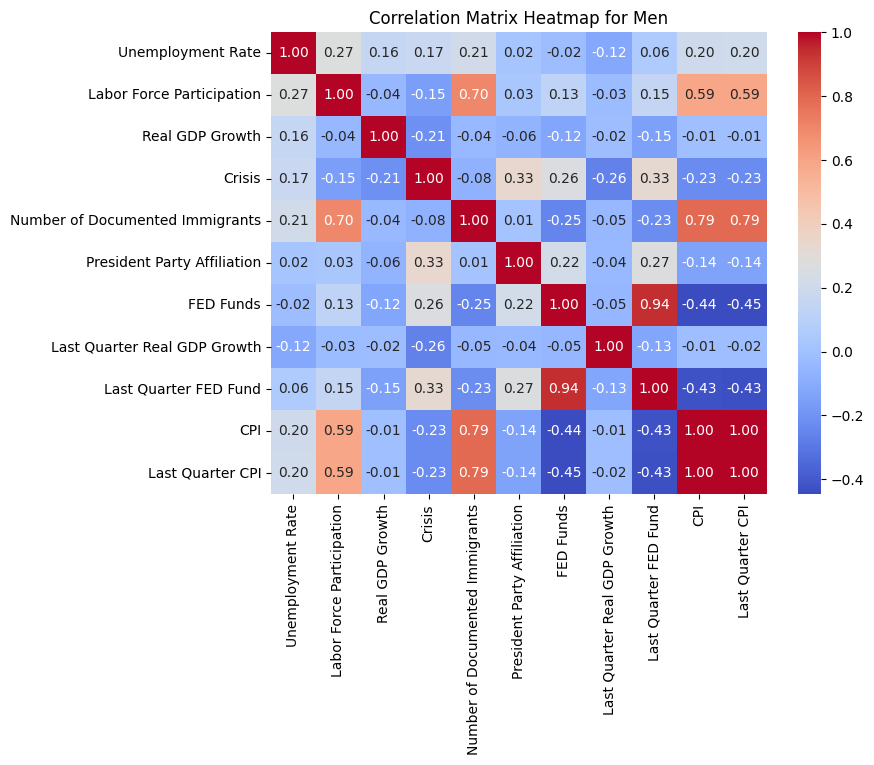

In [991]:
#correlation analysis of all variables of interest for men
subset_columns_men = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Crisis',"Number of Documented Immigrants",'President Party Affiliation', 'FED Funds','Last Quarter Real GDP Growth',
'Last Quarter FED Fund','CPI','Last Quarter CPI']

# Compute the correlation matrix for the subset of columns
correlation_matrix_men = df_men[subset_columns_men].corr()
# print("\nCorrelation matrix for men unemployment rate:")
# print(correlation_matrix_men)

#print correlation for men
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_men, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Men')
plt.show()

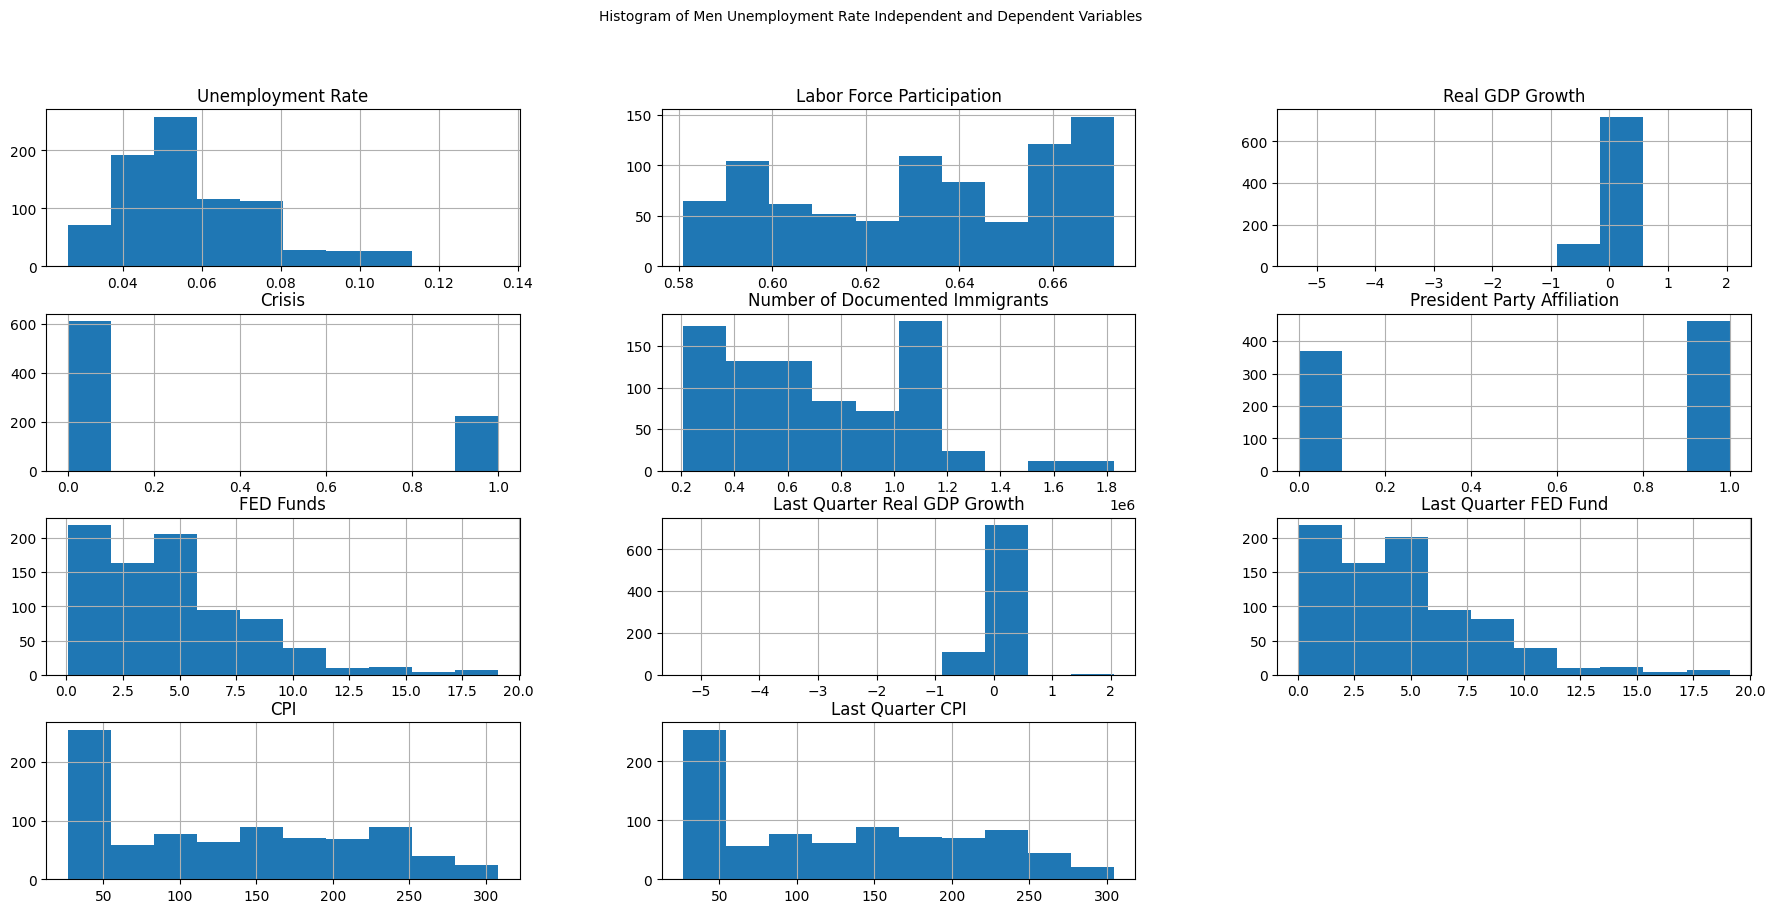

In [925]:
# Create histograms for the subset of columns to understand if any data need transformation
df_men[subset_columns_men].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

#Many data are skewed and require transformation

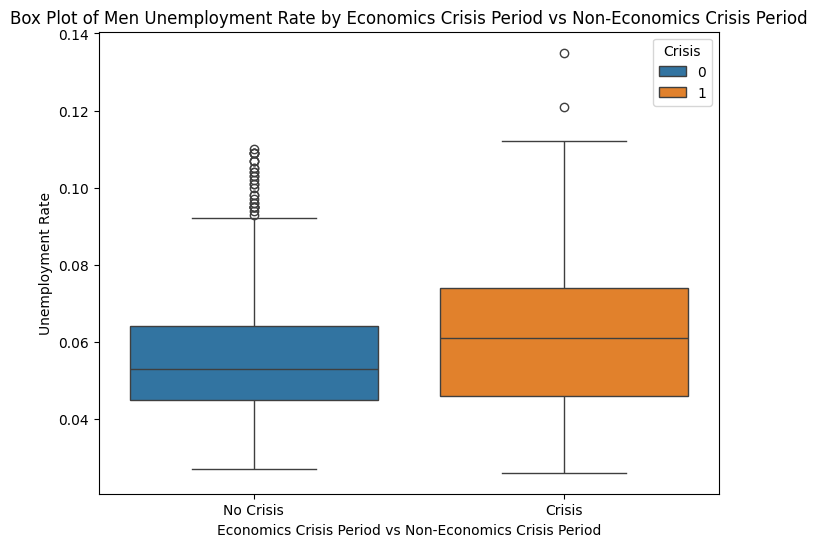

In [888]:
# Create a box plot with hue for men
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_men)
plt.title('Box Plot of Men Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()

In [990]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) to identify outlier
Q1 = df_men['Unemployment Rate'].quantile(0.25)
Q3 = df_men['Unemployment Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df_men[(df_men['Unemployment Rate'] < lower_bound) | (df_men['Unemployment Rate'] > upper_bound)]

# print("\nOutliers using IQR method:")
# print(outliers_iqr)

In [989]:
#drop NA for men population for regression analysis
df_men=df_men.dropna()
nan_counts = df_men.isna().sum()

# print("Number of NaNs in each column:")
# print(nan_counts)

In [928]:
#Adding crisis interaction term 
df_men2=df_men.copy()
df_men2['Crisis_FED'] = df_men2['Crisis']*df_men2['Last Quarter FED Fund']
df_men2['Crisis_Labor'] = df_men2['Crisis']*df_men2['Labor Force Participation']
df_men2['Crisis_GDP'] = df_men2['Crisis']*df_men2['Last Quarter Real GDP Growth']
df_men2['Crisis_President'] = df_men2['Crisis']*df_men2['President Party Affiliation']
df_men2['Crisis_CPI'] = df_men2['Crisis']*df_men['CPI']
df_men2['Crisis_LastQCPI'] = df_men2['Crisis']*df_men['Last Quarter CPI']

In [891]:
#Drop outliers
df_men2 = df_men2[~((df_men2['Unemployment Rate'] < lower_bound) | (df_men2['Unemployment Rate'] > upper_bound))]
df_men2.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Year,Crisis,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.80,1954,1,0.80,0.586,0.182825,1.0,26.78
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,0.271374,1.22,1954,1,1.22,0.581,0.271374,1.0,26.77
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,0.348626,1.07,1955,0,0.00,0.000,0.000000,0.0,0.00
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.410838,0.85,1955,0,0.00,0.000,0.000000,0.0,0.00
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.452714,0.83,1955,0,0.00,0.000,0.000000,0.0,0.00


In [986]:
# #Running multiple regression analysis without data transformation for men population
# X = df_men2[['Labor Force Participation','Number of Documented Immigrants','FED Funds', 'Last Quarter FED Fund','Crisis_President', 'Crisis_Labor','Last Quarter CPI']]
# X = sm.add_constant(X)
# model1_men = sm.OLS(df_men2['Unemployment Rate'], X).fit()
# # Get the residuals
# residual_men1 = model1_men.resid
# print("Multiple regression without log transformation:")
# print(model1_men.summary())

In [985]:
# #diagnostic for OLS Model 1
# # Q-Q plot for the model1_men residuals
# plt.figure(figsize=(8, 6))
# sm.qqplot(residual_men1, line='s')
# plt.title('Q-Q Plot of Residuals from Men Unemployment OLS Model')
# plt.show()

In [987]:
# # Shapiro-Wilk test for normality of residual
# shapiro_test = shapiro(residual_men1)
# print('Shapiro-Wilk Test:')
# print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

#Residuals are not normal

In [932]:
df_men3=df_men2.copy()
df_men3.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Last Quarter CPI,Year,Crisis,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI,Crisis_LastQCPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.80,26.86,1954,1,0.80,0.586,0.182825,1.0,26.78,26.86
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,0.271374,1.22,26.85,1954,1,1.22,0.581,0.271374,1.0,26.77,26.85
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,0.348626,1.07,26.81,1955,0,0.00,0.000,0.000000,0.0,0.00,0.00
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.410838,0.85,26.72,1955,0,0.00,0.000,0.000000,0.0,0.00,0.00
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.452714,0.83,26.78,1955,0,0.00,0.000,0.000000,0.0,0.00,0.00


In [933]:
#Log transform a subset of dependent variables

df_men3['Log_Labor Force Participation'] = np.log(df_men3['Labor Force Participation'])/10
df_men3['Log_Number of Documented Immigrants'] = np.log(df_men3['Number of Documented Immigrants'])
df_men3['Log_FED Funds'] = np.log(df_men3['FED Funds']/10)
df_men3['Log_Unemployment Rate'] = np.log(df_men3['Unemployment Rate'])
df_men3['Log_CPI'] = np.log(df_men3['CPI']/100)
df_men3['Log_Last Quarter FED Fund'] = np.log(df_men3['Last Quarter FED Fund']/10)
df_men3['Log_Last Quarter CPI'] = np.log(df_men3['Last Quarter CPI']/100)

df_men3.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,...,Crisis_President,Crisis_CPI,Crisis_LastQCPI,Log_Labor Force Participation,Log_Number of Documented Immigrants,Log_FED Funds,Log_Unemployment Rate,Log_CPI,Log_Last Quarter FED Fund,Log_Last Quarter CPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.80,...,1.0,26.78,26.86,-0.053444,12.246144,-2.488915,-2.956512,-1.317515,-2.525729,-1.314532
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,0.271374,1.22,...,1.0,26.77,26.85,-0.054300,12.246144,-2.055725,-2.995732,-1.317888,-2.103734,-1.314904
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,0.348626,1.07,...,0.0,0.00,0.00,-0.053444,12.379143,-1.973281,-3.036554,-1.317888,-2.234926,-1.316395
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.410838,0.85,...,0.0,0.00,0.00,-0.053785,12.379143,-2.047943,-3.101093,-1.316022,-2.465104,-1.319758
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.452714,0.83,...,0.0,0.00,0.00,-0.053614,12.379143,-2.002481,-3.101093,-1.317142,-2.488915,-1.317515


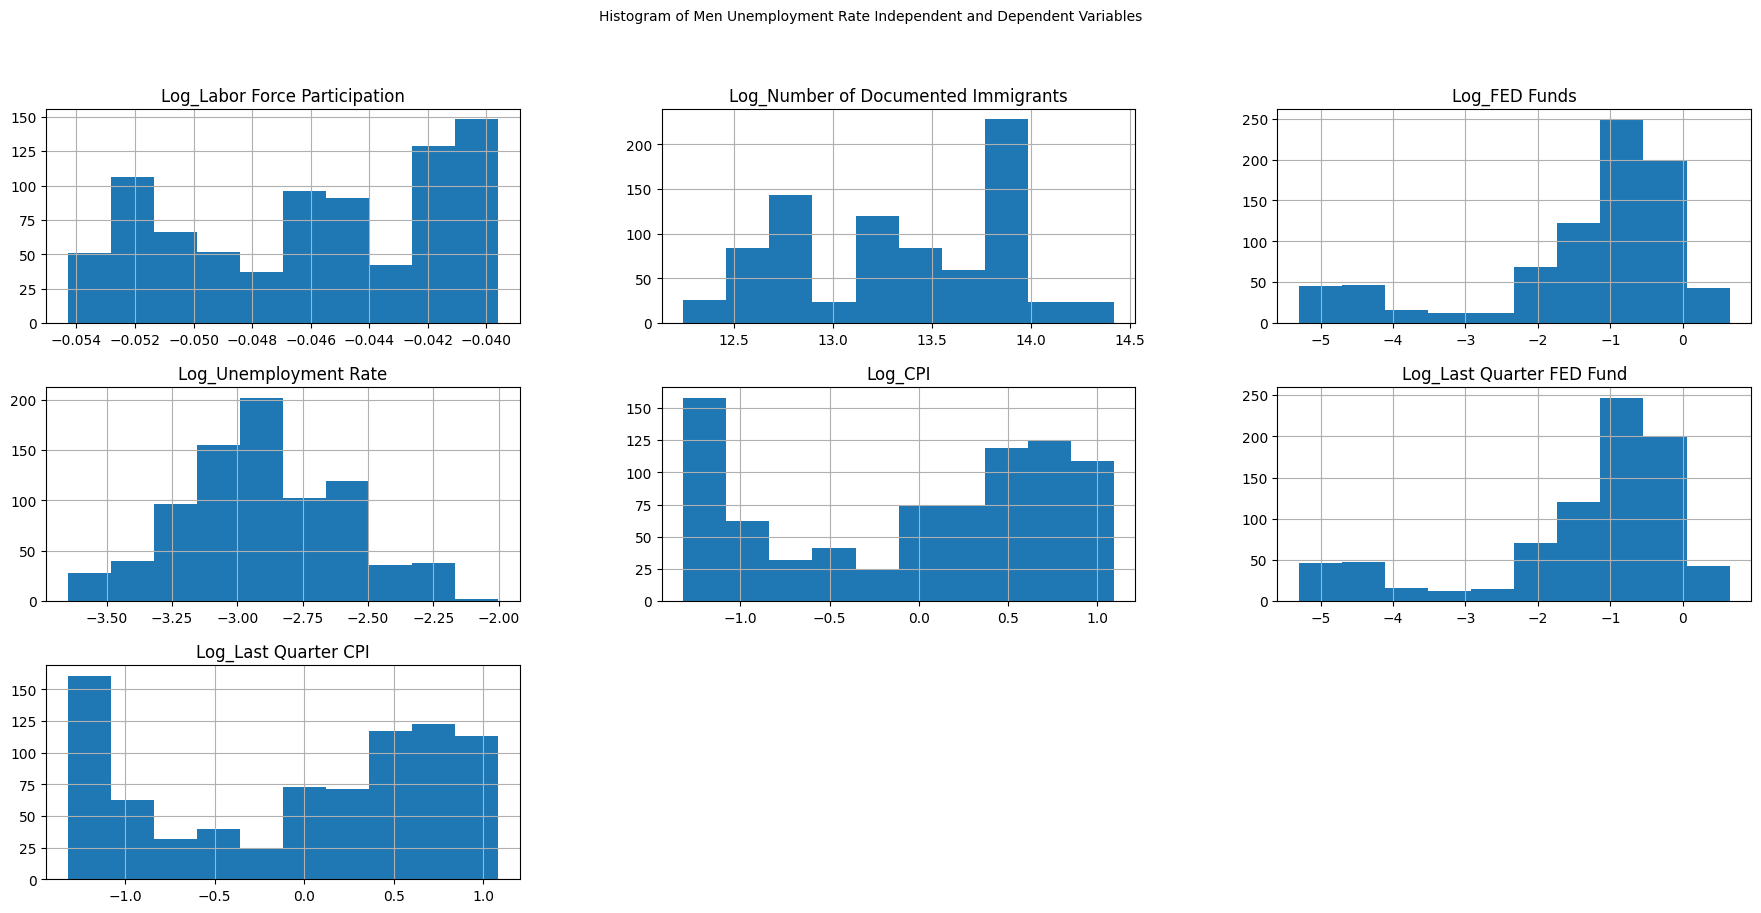

In [934]:
# Create histograms for the subset of columns to understand if any data need transformation
subset_columns_men3=['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_FED Funds','Log_Unemployment Rate','Log_CPI','Log_Last Quarter FED Fund','Log_Last Quarter CPI']
df_men3[subset_columns_men3].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

In [935]:
#Adding crisis interaction term 
df_men3['Crisis_LogFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund']
df_men3['Crisis_LogImmig'] = df_men3['Crisis']*df_men3['Log_Number of Documented Immigrants']
df_men3['Crisis_LogCPI'] = df_men3['Crisis']*df_men3['Log_CPI']
df_men3['Crisis_LogLastQFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund'] 
df_men3['Crisis_LogLaborForce'] = df_men3['Crisis']*df_men3['Log_Labor Force Participation'] 
df_men3['Crisis_LogLastQCPI'] = df_men3['Crisis']*df_men3['Log_Last Quarter CPI']

In [988]:
# #Running multiple regression analysis without data transformation for men population
# X = df_men3[['Log_Labor Force Participation','Log_CPI','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund','Crisis_President', 'Crisis_LogCPI','Crisis_LogLastQFED', 'Crisis_LogLaborForce']]
# X = sm.add_constant(X)
# model3_men = sm.OLS(df_men3['Log_Unemployment Rate'], X).fit()
# # Get the residuals
# residual_men3 = model3_men.resid
# print("Multiple regression without log transformation:")
# print(model3_men.summary())

In [984]:
# # Shapiro-Wilk test for normality of residual
# shapiro_test = shapiro(residual_men3)
# print('Shapiro-Wilk Test:')
# print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

In [981]:
#Running multiple regression analysis without data transformation for men population
X = df_men4[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund', 'Crisis_LogCPI', 'Crisis_LogLaborForce',"Prev Two Quarter Log FED Fund",'President Party Affiliation']]
X = sm.add_constant(X)
model4_men = sm.OLS(df_men4['Log_Unemployment Rate'], X).fit()
# Get the residuals
residual_men4 = model4_men.resid
print("Multiple regression without log transformation:")
print(model4_men.summary())

Multiple regression without log transformation:
                              OLS Regression Results                             
Dep. Variable:     Log_Unemployment Rate   R-squared:                       0.298
Model:                               OLS   Adj. R-squared:                  0.292
Method:                    Least Squares   F-statistic:                     48.91
Date:                   Wed, 12 Jun 2024   Prob (F-statistic):           5.32e-58
Time:                           17:57:13   Log-Likelihood:                -59.638
No. Observations:                    814   AIC:                             135.3
Df Residuals:                        806   BIC:                             172.9
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [983]:
# Shapiro-Wilk test for normality of residual
shapiro_test = shapiro(residual_men4)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

Shapiro-Wilk Test:
Statistic: 0.9968584345498748, p-value: 0.1114004193702426


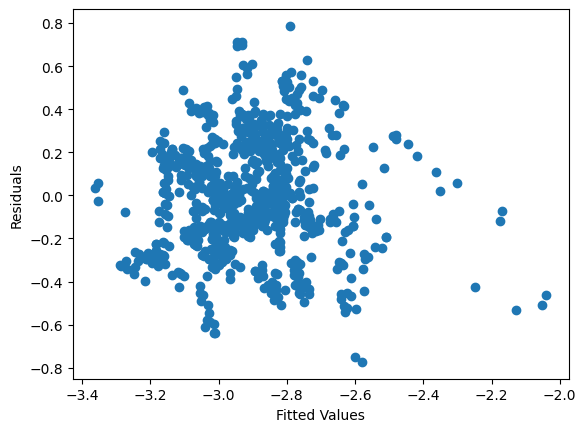

In [992]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model4_men.fittedvalues, model4_men.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [993]:
#Ensure residuals are independent
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(model4_men.resid)
print('Durbin-Watson Test:', dw_test)

#Confirm residuals are independent

Durbin-Watson Test: 0.08751286250292946


In [704]:
#merge all data for all women 
df_women= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_women, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_women.head()

,DATE,LNS14000002,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,6.3,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.2,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.4,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.8,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.6,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [705]:
#normalize GDP via CPI, and other data
df_women["Real GDP"] = df_women['USALORSGPNOSTSAM'] / df_women['CPI']
df_women["Real GDP1"] = df_women['USALORSGPNOSTSAM1'] / df_women['CPI']
df_women["Real GDP Growth"] = (df_women["Real GDP1"] - df_women["Real GDP"])/df_women["Real GDP"]*100
df_women=df_women[['YearMonth', 'LNS14000002','Labor Force Participation','Real GDP Growth',"NUMBER OF DOCUMENTED IMMIGRANTS",'President Party Affiliation','FEDFUNDS']]
#scale labor force and umemployment data
df_women['Labor Force Participation'] = df_women['Labor Force Participation']/100
df_women['LNS14000002'] = df_women['LNS14000002']/100
#add one month lagged real GDP growth
df_women["Lagged Real GDP Growth"]= df_women['Real GDP Growth'].shift(1)
df_women.head()

,YearMonth,LNS14000002,Labor Force Participation,Real GDP Growth,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,Lagged Real GDP Growth
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838


In [706]:
#change project 1 men dataset name
df_women.rename(columns={'YearMonth': 'Date', 'LNS14000002': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lagged Real GDP Growth":"Lagged Real GDP Growth","NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds'}, inplace=True)
df_women.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838


In [707]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_women['Year'] = df_women['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_women['Crisis'] = df_women['Year'].apply(lambda x: 1 if x in crisis_years else 0)

# Display the DataFrame
df_women.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth,Year,Crisis
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN,1954,1
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825,1954,1
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374,1954,1
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626,1954,1
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838,1954,1


In [710]:
#correlation analysis of all variables of interest for women
subset_columns_women = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Crisis','President Party Affiliation', 'FED Funds']

# Compute the correlation matrix for the subset of columns
correlation_matrix_women = df_women[subset_columns_women].corr()
print("\nCorrelation matrix for unemployment rate and economics indicator:")
print(correlation_matrix_women)


Correlation matrix for unemployment rate and economics indicator:
                             Unemployment Rate  Labor Force Participation  \
Unemployment Rate                     1.000000                  -0.056900   
Labor Force Participation            -0.056900                   1.000000   
Real GDP Growth                       0.178060                  -0.049154   
Lagged Real GDP Growth                0.037076                  -0.032941   
Crisis                                0.225898                  -0.161489   
President Party Affiliation           0.043588                   0.030440   
FED Funds                             0.189037                   0.134269   

                             Real GDP Growth  Lagged Real GDP Growth  \
Unemployment Rate                   0.178060                0.037076   
Labor Force Participation          -0.049154               -0.032941   
Real GDP Growth                     1.000000                0.619575   
Lagged Real GDP Growth      

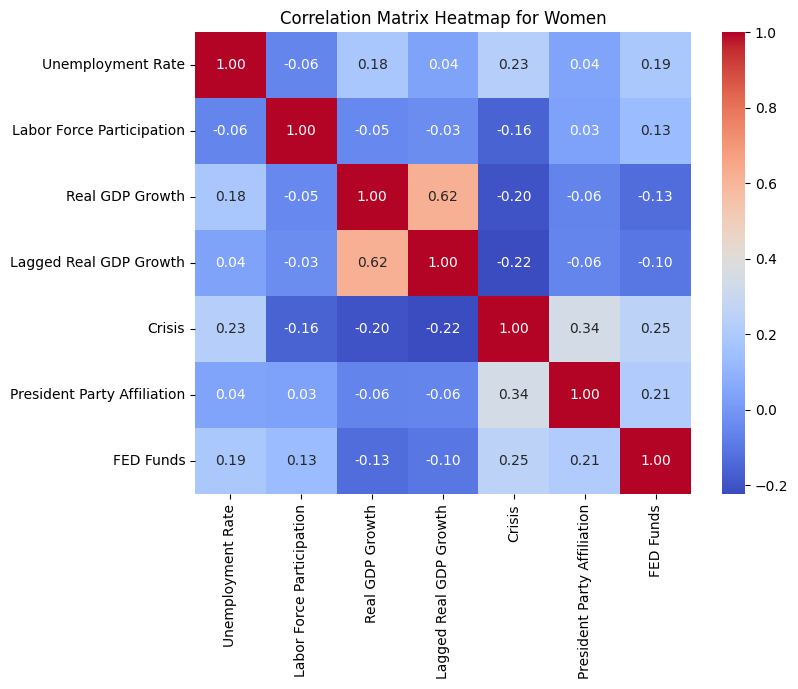

In [711]:
#print correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_women, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Women')
plt.show()

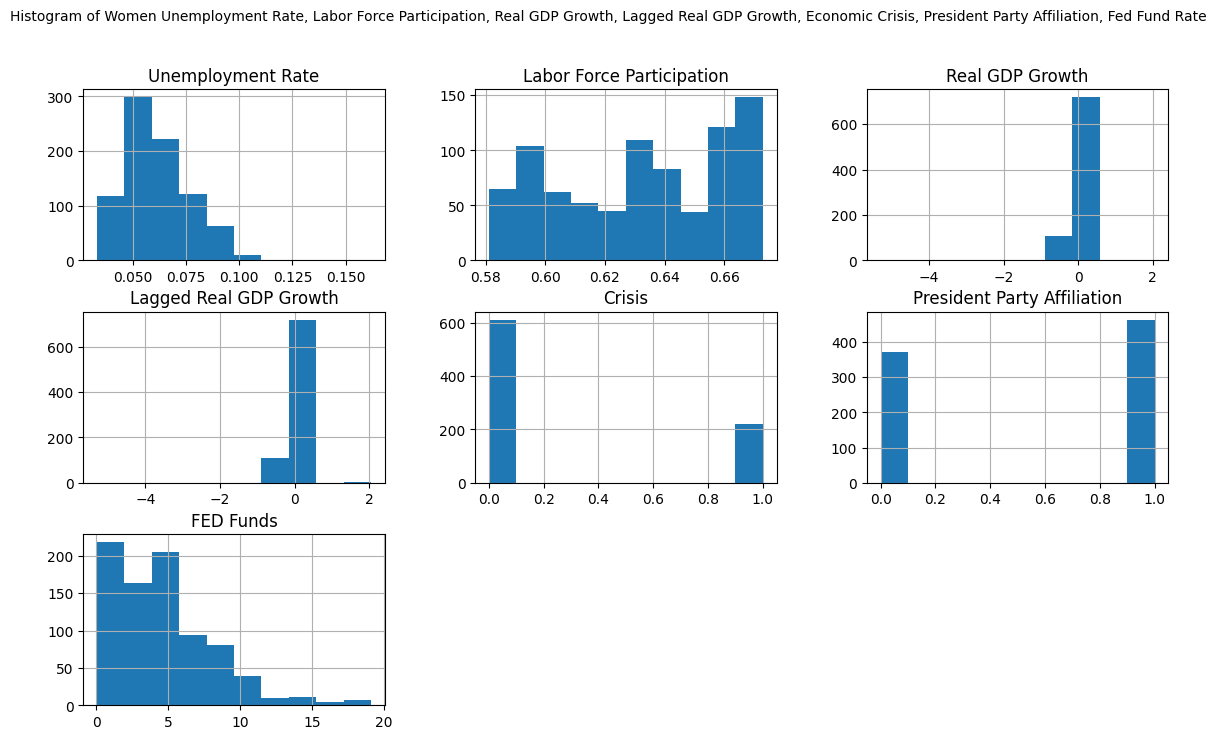

In [712]:
# Create histograms for the subset of columns to understand if any data need transformation
df_women[subset_columns_women].hist(figsize=(14, 8), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Women Unemployment Rate, Labor Force Participation, Real GDP Growth, Lagged Real GDP Growth, Economic Crisis, President Party Affiliation, Fed Fund Rate', fontsize=10)
plt.xlabel('Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Show the plot
plt.show()

#Many data are skewed and require transformation

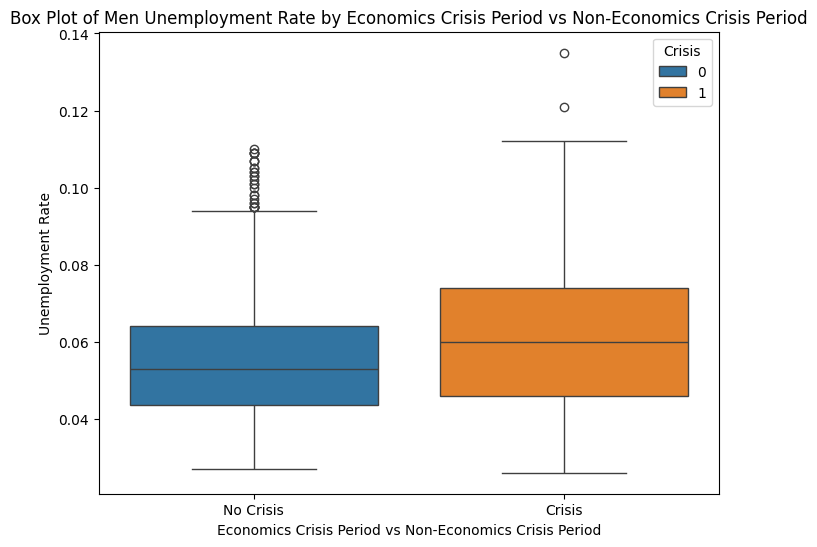

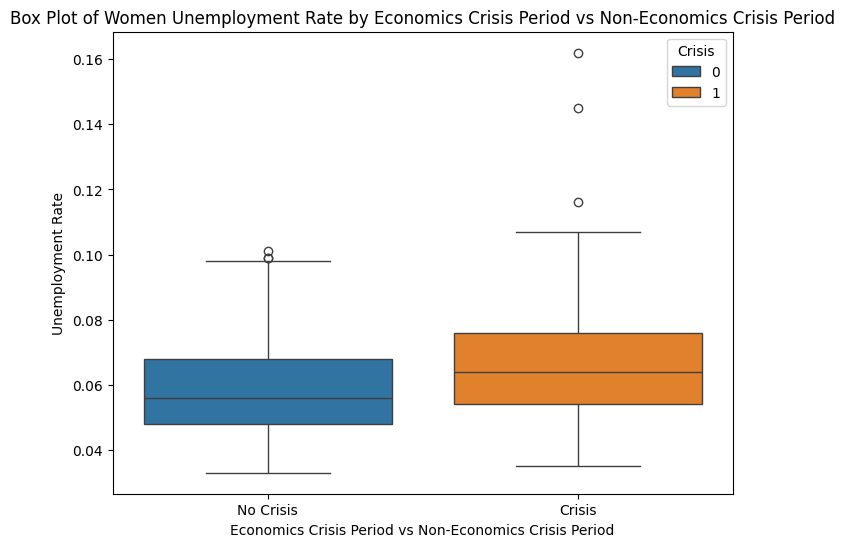

In [651]:
# Create a box plot with hue for women
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_women)
plt.title('Box Plot of Women Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()

Shapiro-Wilk Test:
Statistic: 0.9533374454453448, p-value: 1.8272200577097693e-15


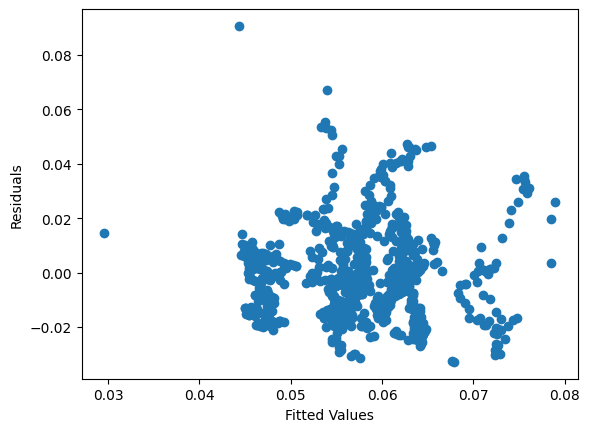

Breusch-Pagan Test: (36.54207637665046, 7.398466870437769e-07, 7.592961037198872, 5.524404548168934e-07)


Durbin-Watson Test: 0.0690565781728417


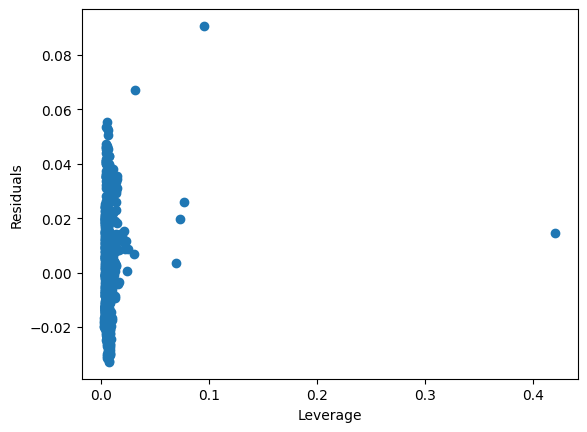

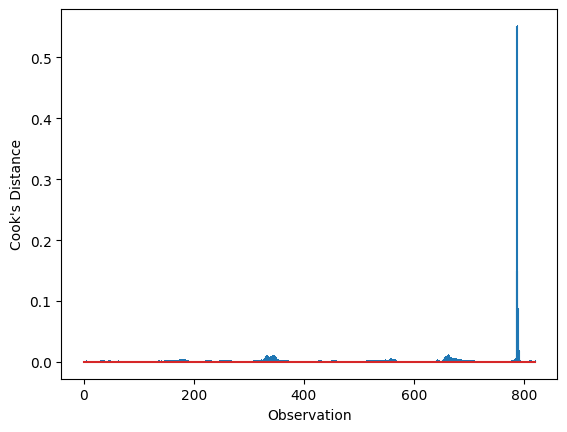

In [654]:

# X = np.log(df_men[['Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Crisis']])
# model2_men = sm.OLS(df_men['Y'], X).fit()
# print("\nMultiple regression with log transformation for X1:")
# print(model2_men.summary())


In [713]:
#drop NA for women population for regression analysis
df_women=df_women.dropna()
nan_counts = df_women.isna().sum()

print("Number of NaNs in each column:")
print(nan_counts)

Number of NaNs in each column:
Date                               0
Unemployment Rate                  0
Labor Force Participation          0
Real GDP Growth                    0
Number of Documented Immigrants    0
President Party Affiliation        0
FED Funds                          0
Lagged Real GDP Growth             0
Year                               0
Crisis                             0
dtype: int64


In [720]:
#Running multiple regression analysis without data transformation for women population
X = df_women[['Labor Force Participation','Lagged Real GDP Growth','Crisis','President Party Affiliation', 'FED Funds']]
X = sm.add_constant(X)
model1_women = sm.OLS(df_women['Unemployment Rate'], X).fit()
residual_women = model1_women.resid
print("Multiple regression without log transformation:")
print(model1_women.summary())

Multiple regression without log transformation:
                            OLS Regression Results                            
Dep. Variable:      Unemployment Rate   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     15.53
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           1.29e-14
Time:                        21:05:04   Log-Likelihood:                 2298.5
No. Observations:                 821   AIC:                            -4585.
Df Residuals:                     815   BIC:                            -4557.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

<Figure size 800x600 with 0 Axes>

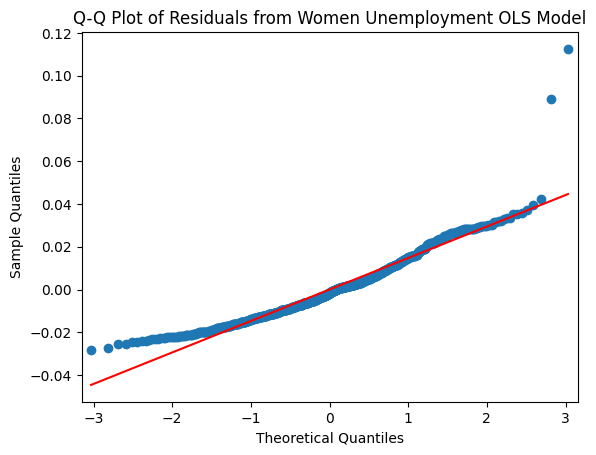

In [722]:
# Q-Q plot for the model1_men residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residual_women, line='s')
plt.title('Q-Q Plot of Residuals from Women Unemployment OLS Model')
plt.show()

In [725]:
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residual_women)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')


Shapiro-Wilk Test:
Statistic: 0.9356173474904064, p-value: 2.4232967155984886e-18


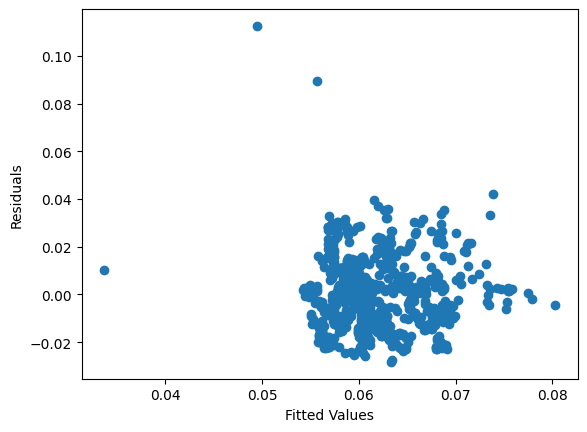

Breusch-Pagan Test: (61.15727299317319, 7.006198127816126e-12, 13.119340547162556, 2.6390114246249666e-12)


In [727]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model1_women.fittedvalues, model1_women.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model1_women.resid, model1_women.model.exog)
print('Breusch-Pagan Test:', bp_test)

In [729]:
#Ensure residuals are independent
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(model1_women.resid)
print('Durbin-Watson Test:', dw_test)

Durbin-Watson Test: 0.11719132432086807


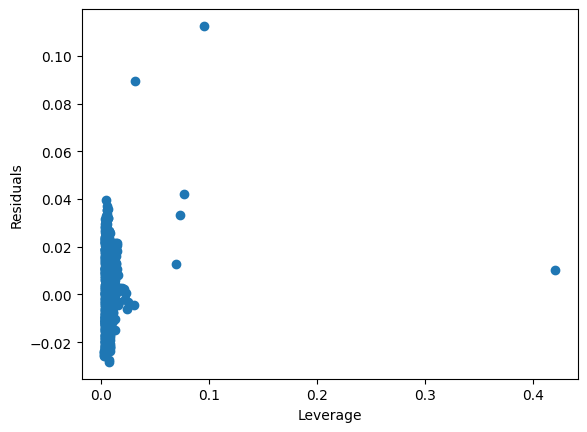

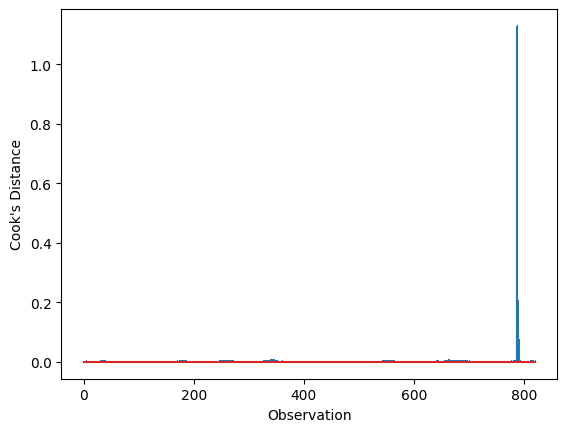

In [730]:
#Check for outliers and their influences
influence = model1_women.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Plot leverage vs. residuals
plt.scatter(leverage, model1_women.resid)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.show()

# Plot Cook's distance
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

## Total Population Summary

In [ ]:
#merge all data for all population
df_all= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_df, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_edu_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_all.head()

In [ ]:
#normalize GDP via CPI
df_all["Real GDP"] = df_all['USALORSGPNOSTSAM'] / df_all['CPI']
df_all["Real GDP1"] = df_all['USALORSGPNOSTSAM1'] / df_all['CPI']
df_all["Real GDP Growth"] = (df_all["Real GDP1"] - df_all["Real GDP"])/df_all["Real GDP"]*100
df_all=df_all[['YearMonth', 'Unemployment Rate','Labor Force Participation','Real GDP Growth', '% Highest degree is middle school', '% Highest degree is High School', '% Highest degree is  College (4 + years)' ,'NUMBER OF DOCUMENTED IMMIGRANTS','President Party Affiliation','FEDFUNDS']]
#scale labor force and umemployment data
df_all['Labor Force Participation'] = df_all['Labor Force Participation']/100
df_all['Unemployment Rate'] = df_all['Unemployment Rate']/100
#add one month lagged real GDP growth
df_all["Lagged Real GDP Growth"]= df_all['Real GDP Growth'].shift(1)
df_all.head()

In [ ]:
#change project 1 dataset name
df_all.rename(columns={'YearMonth': 'Date', 'Unemployment Rate': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', '% Highest degree is middle school': "Middle School Degree%",'% Highest degree is High School': "High School Degree%",
                    '% Highest degree is  College (4 + years)': "College Degree%", "Lagged Real GDP Growth":"Lagged Real GDP Growth",'President Party Affiliation':'President Party Affiliation','NUMBER OF DOCUMENTED IMMIGRANTS':'Number of Documented Immigrants','FEDFUNDS':'FED Funds'}, inplace=True)
df_all.head()

In [ ]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_all['Year'] = df_all['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_all['Crisis'] = df_all['Year'].apply(lambda x: 1 if x in crisis_years else 0)

# Display the DataFrame
df_all.head()


In [ ]:
#correlation analysis of all variables of interest
subset_columns = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Middle School Degree%',
                  'High School Degree%', 'College Degree%','Crisis','Number of Documented Immigrants','President Party Affiliation','FED Funds']

# Compute the correlation matrix for the subset of columns
correlation_matrix = df_all[subset_columns].corr()
print("\nCorrelation matrix for unemployment rate and economics indicator:")
print(correlation_matrix)

In [ ]:
#print correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Create histograms for the subset of columns to understand if any data need transformation
df_all[subset_columns].hist(figsize=(14, 8), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Unemployment Rate, Labor Force Participation, Real GDP Growth, Lagged Real GDP Growth, Middle School Degree%, High School Degree%, College Degree%, Economic Crisis, President Party Affiliation, Fed Fund Rate', fontsize=10)
plt.xlabel('Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Show the plot
plt.show()

#Many data are skewed and require transformation

In [ ]:
# Create a box plot with hue
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_all)
plt.title('Box Plot of Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()